# Interface Analysis

Analysis of the interfaces between Antibody and Antigens:

1. Average Size of Interface (number of residues in Ab and Ag)
2. Most prominent residues


In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import scipy.spatial as sp
import warnings
import matplotlib.pyplot as plt
import seaborn as sns


warnings.filterwarnings("ignore")
from abag_affinity.utils.config import read_config

from abag_affinity.utils.pdb_reader import read_file

In [2]:
INTERFACE_DISTANCES = [5]
INTERFACE_HULL_SIZE = 7

In [3]:
config = read_config("../../config.yaml")

summary_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"]["abag_affinity"]["folder_path"], config["DATASETS"]["abag_affinity"]["summary"])
pdb_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"]["abag_affinity"]["folder_path"], config["DATASETS"]["abag_affinity"]["pdb_path"])

dataset = pd.read_csv(summary_path, index_col=0)
path = os.path.join(config["DATASETS"]["path"], config["DATASETS"]["abag_affinity"]["folder_path"])

In [4]:
dataset

,pdb,filename,chain_infos,-log(Kd),delta_g,validation,test
1bvk,1bvk,1bvk.pdb,"{'h': 0, 'l': 0, 'f': 1}",7.853872,-10.530000,2,False
1dqj,1dqj,1dqj.pdb,"{'h': 0, 'l': 0, 'c': 1}",8.543634,-11.450000,4,False
1e6j,1e6j,1e6j.pdb,"{'h': 0, 'l': 0, 'p': 1}",7.537602,-10.280000,4,False
1f90,1f90,1f90.pdb,"{'h': 0, 'l': 0, 'e': 1}",7.924453,-10.800000,0,True
1fsk,1fsk,1fsk.pdb,"{'h': 0, 'l': 0, 'g': 1}",9.619789,-13.123740,4,False
...,...,...,...,...,...,...,...
6ii8,6ii8,6ii8.pdb,"{'h': 0, 'l': 0, 'c': 1}",6.413413,-8.749460,3,False
6ii9,6ii9,6ii9.pdb,"{'h': 0, 'l': 0, 'c': 1}",7.712198,-10.521321,2,False
6mhr,6mhr,6mhr.pdb,"{'h': 0, 'l': 0, 'f': 1}",7.657577,-10.446805,4,False
6mi2,6mi2,6mi2.pdb,"{'h': 0, 'l': 0, 'c': 1}",7.161151,-9.769558,4,False


In [5]:
from abag_affinity.utils.pdb_processing import remove_redundant_chains
import string
from ast import literal_eval
alphabet_letters = set(string.ascii_lowercase)

def get_residue_count_and_interface_size(dataset, interface_distance_threshold):
    interface_sizes = []
    interface_resiude_count = {
        "antibody": defaultdict(int),
        "antigen": defaultdict(int)
    }
    
    resiude_count = {
        "antibody": defaultdict(int),
        "antigen": defaultdict(int)
    }


    no_antibody_antigen_contact = []

    for i, row in tqdm(dataset.iterrows(), total=len(dataset)):
        pdb_id = row["pdb"]
        path = os.path.join(pdb_path, row["filename"]) 
        structure, header = read_file(pdb_id, path)
        remove_redundant_chains(structure)
        
        chain_id2protein = literal_eval(row["chain_infos"])
        
        chain_id2protein = { k: "antibody" if v == 1 else "antigen" for k,v in chain_id2protein.items() }

        interface_count = {
            "antibody": [],
            "antigen": []
        }
        


        residue_ca_coordinates = defaultdict(list)
        residue_n_coordinates = defaultdict(list)
        residue_c_coordinates = defaultdict(list)
        residue_o_coordinates = defaultdict(list)

        residue_name = defaultdict(list)

        for chain in structure.get_chains():
            for residue in chain.get_residues():
                if "CA" in residue:
                    residue_ca_coordinates[chain.id.lower()].append(residue["CA"].coord)
                else:
                    residue_ca_coordinates[chain.id.lower()].append((np.nan, np.nan, np.nan))
                if "N" in residue:
                    residue_n_coordinates[chain.id.lower()].append(residue["N"].coord)
                else:
                    residue_n_coordinates[chain.id.lower()].append((np.nan, np.nan, np.nan))
                if "C" in residue:
                    residue_c_coordinates[chain.id.lower()].append(residue["C"].coord)
                else:
                    residue_c_coordinates[chain.id.lower()].append((np.nan, np.nan, np.nan))
                if "O" in residue:
                    residue_o_coordinates[chain.id.lower()].append(residue["O"].coord)
                else:
                    residue_o_coordinates[chain.id.lower()].append((np.nan, np.nan, np.nan))
                residue_name[chain.id.lower()].append(residue.resname)
                if chain.id.lower() not in chain_id2protein:
                    #print(f"Chain ID {chain.id.lower()} not found in chain_id2protein dict for pdb_id {pdb_id}")
                    #print(chain_id2protein)
                    continue
                resiude_count[chain_id2protein[chain.id.lower()]][residue.resname] += 1
        
        all_chains = list(structure.get_chains())
        for ii, chain in enumerate(all_chains):    
            for o_chain in all_chains[ii + 1:]:
                if chain_id2protein.get(chain.id.lower()) != chain_id2protein.get(o_chain.id.lower()) and len(residue_ca_coordinates[chain.id.lower()]) > 0 and len(residue_ca_coordinates[o_chain.id.lower()]) > 0 and chain_id2protein.get(chain.id.lower()) is not None and chain_id2protein.get(o_chain.id.lower()) is not None:
                    all_distances = []
                    for atom_coordinates in [residue_ca_coordinates,residue_n_coordinates,residue_c_coordinates,residue_o_coordinates]:
                        for o_atom_coordinates in [residue_ca_coordinates,residue_n_coordinates,residue_c_coordinates,residue_o_coordinates]:
                            all_distances.append(sp.distance_matrix(np.array(atom_coordinates[chain.id.lower()]), 
                                                                np.array(o_atom_coordinates[o_chain.id.lower()])))
                    
                    all_distances = np.stack(all_distances)
                    min_distances = np.amin(all_distances, axis=0)
                    
                    distances = sp.distance_matrix(np.array(residue_ca_coordinates[chain.id.lower()]), 
                                                                np.array(residue_ca_coordinates[o_chain.id.lower()]))

                    contacts = np.where(min_distances < interface_distance_threshold)
                    if len(contacts[0]) == 0:
                        continue
                    for res_contacts_id in np.unique(contacts[0]):
                        interface_resiude_count[chain_id2protein.get(chain.id.lower())][residue_name[chain.id.lower()][res_contacts_id]] += 1
                    for res_contacts_id in np.unique(contacts[1]):
                        interface_resiude_count[chain_id2protein.get(o_chain.id.lower())][residue_name[o_chain.id.lower()][res_contacts_id]] += 1

                    interface_count[chain_id2protein.get(chain.id.lower())].append(len(np.unique(contacts[0])))
                    interface_count[chain_id2protein.get(o_chain.id.lower())].append(len(np.unique(contacts[1])))
        if len(interface_count["antibody"]) == 0:
            no_antibody_antigen_contact.append(pdb_id)
        interface_sizes.append(interface_count)
        
        
    return interface_sizes, interface_resiude_count, resiude_count, no_antibody_antigen_contact

In [6]:
interface_features = {}

for distance in INTERFACE_DISTANCES:
    interface_features[distance] = get_residue_count_and_interface_size(dataset, distance)

#interface_sizes, interface_resiude_count, resiude_count, no_antibody_antigen_contact = get_residue_count_and_interface_size(dataset, 10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 385/385 [00:19<00:00, 19.45it/s]


### Analysis of Antibody & Antigen Binding Residues

In [7]:
colors = sns.color_palette()

def plot_binding_residues(interface_features):
    interface_sizes, interface_resiude_count, resiude_count, no_antibody_antigen_contact = interface_features
    plot_x_frequent = 10
    width = 0.4

    fix, ax = plt.subplots(2,1, figsize=(15,8))

    for i, protein in enumerate(interface_resiude_count.keys()):
        total_interface_contact_residues = sum(interface_resiude_count[protein].values())
        relative_interface_values = {res: count/total_interface_contact_residues * 100 for res, count in interface_resiude_count[protein].items()}

        total_contact_residues = sum(resiude_count[protein].values())
        relative_values = {res: count/total_contact_residues * 100 for res, count in resiude_count[protein].items()}

        sorted_dict = {k: v for k, v in sorted(relative_interface_values.items(), key=lambda item: item[1], reverse=True)}
        indices = np.arange(plot_x_frequent)
        most_frequent_aa = list(sorted_dict.keys())[:plot_x_frequent]

        interface_plot = ax[i].bar(indices, [relative_interface_values[aa] for aa in most_frequent_aa], width=width, align='center', color=colors[0])
        protein_plot = ax[i].bar(indices + width, [relative_values[aa] for aa in most_frequent_aa], width=width, align='center', color=colors[1])

        ax[i].set_xticks(indices + (width/2), list(sorted_dict.keys())[:plot_x_frequent])
        ax[i].set_title("{} most frequent residues of {}".format(plot_x_frequent, protein))

        ax[i].set_ylabel("Relative Frequency (%)")

        interface_name = "Paratope" if protein == "antibody" else "Epitope"
        ax[i].legend( (interface_plot, protein_plot), (interface_name, "Full Protein") )
        
    plt.savefig("./plots/abag_affinity_residue_distribution.png")
    plt.show()

Binding Residues for Distance Cutoff : 5


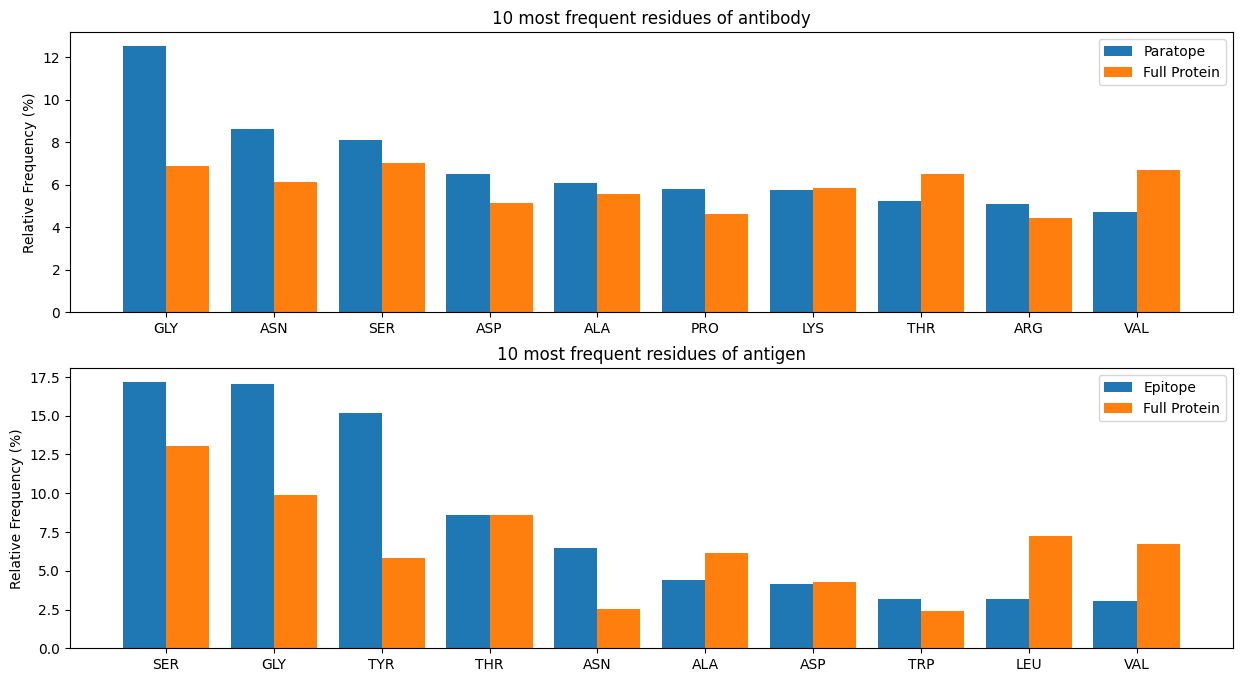

In [8]:
for distance in INTERFACE_DISTANCES:
    print("Binding Residues for Distance Cutoff :", distance)
    plot_binding_residues(interface_features[distance])

### Analysis of Interface Sizes

In [9]:
def calculate_interface_sizes(interface_features):
    interface_sizes, interface_resiude_count, resiude_count, no_antibody_antigen_contact = interface_features

    all_antibody_interfaces = []
    all_antigen_interfaces = []
    all_antibody_interface_size = []
    all_antigen_interface_size = []
    for interface_size in interface_sizes:
        for ab_interface_size in interface_size["antibody"]:
            all_antibody_interfaces.append(ab_interface_size)
        for ag_interface_size in interface_size["antigen"]:
            all_antigen_interfaces.append(ab_interface_size)
        all_antibody_interface_size.append(sum(interface_size["antibody"]))    
        all_antigen_interface_size.append(sum(interface_size["antigen"])) 
    print('Average size of an interface on the antibody >>> {:.4f} ({:.4f})'.format(np.mean(all_antibody_interfaces), np.std(all_antibody_interfaces)))
    print('Average size of an interface on the antigen >>> {:.4f} ({:.4f})'.format(np.mean(all_antigen_interfaces), np.std(all_antigen_interfaces)))
    print('Average size of the complete interface on the antibody >>> {:.4f} ({:.4f})'.format(np.mean(all_antibody_interface_size), np.std(all_antibody_interface_size)))
    print('Average size of the complete interface on the antigen >>> {:.4f} ({:.4f})'.format(np.mean(all_antigen_interface_size), np.std(all_antigen_interface_size)))
    print('Max size of the complete interface on the antibody >>> {:.0f}'.format(np.max(all_antibody_interface_size)))
    print('Max size of the complete interface on the antigen >>> {:.0f}'.format(np.max(all_antigen_interface_size)))

In [10]:
for distance in INTERFACE_DISTANCES:
    print("Binding Residues for Distance Cutoff :", distance)
    calculate_interface_sizes(interface_features[distance])
    print()

Binding Residues for Distance Cutoff : 5
Average size of an interface on the antibody >>> 3.4160 (2.0961)
Average size of an interface on the antigen >>> 3.8273 (2.1720)
Average size of the complete interface on the antibody >>> 5.6519 (2.6907)
Average size of the complete interface on the antigen >>> 5.6026 (2.6930)
Max size of the complete interface on the antibody >>> 15
Max size of the complete interface on the antigen >>> 15



## Analyse interface edges

In [11]:

AMINO_ACIDS = ["ala","cys","asp","glu","phe","gly","his","ile","lys","leu","met","asn","pro","gln","arg","ser","thr","val","trp","tyr"]
AAA2ID = {aa: i for i, aa in enumerate(AMINO_ACIDS)}
ID2AA = {i: aa for i, aa in enumerate(AMINO_ACIDS)}


RESIDUE_SIDECHAIN_POSTFIXES = {
    'A': ['B'],
    'R': ['B', 'G', 'D', 'E', 'Z', 'H1', 'H2'],
    'N': ['B', 'G', 'D1', 'D2'],
    'D': ['B', 'G', 'D1', 'D2'],
    'C': ['B', 'G'],
    'E': ['B', 'G', 'D', 'E1', 'E2'],
    'Q': ['B', 'G', 'D', 'E1', 'E2'],
    'G': [],
    'H': ['B', 'G', 'D1', 'D2', 'E1', 'E2'],
    'I': ['B', 'G1', 'G2', 'D1'],
    'L': ['B', 'G', 'D1', 'D2'],
    'K': ['B', 'G', 'D', 'E', 'Z'],
    'M': ['B', 'G', 'D', 'E'],
    'F': ['B', 'G', 'D1', 'D2', 'E1', 'E2', 'Z'],
    'P': ['B', 'G', 'D'],
    'S': ['B', 'G'],
    'T': ['B', 'G1', 'G2'],
    'W': ['B', 'G', 'D1', 'D2', 'E1', 'E2', 'E3', 'Z2', 'Z3', 'H2'],
    'Y': ['B', 'G', 'D1', 'D2', 'E1', 'E2', 'Z', 'H'],    
    'V': ['B', 'G1', 'G2'],
}
ATOM_POSTFIXES = ['N', 'CA', 'C', 'O']
for postfixes in RESIDUE_SIDECHAIN_POSTFIXES.values():
    ATOM_POSTFIXES += list(postfixes)

ATOM_POSTFIXES = set(ATOM_POSTFIXES)

ATOM2ID = {atom: i for i, atom in enumerate(ATOM_POSTFIXES)}
ID2ATOM = {i: atom for i, atom in enumerate(ATOM_POSTFIXES)}

In [36]:
datasets = ["abag_affinity", "SKEMPI.v2", "PDBBind", "AntibodyBenchmark", "DMS" ]
name_mapping = {
    "abag_affinity": "AbAg-Affinity",
    "SKEMPI.v2": "SKEMPI.v2", 
    "PDBBind": "PDBBind",
    "AntibodyBenchmark": "AB-benchmark",
    "DMS": "DMS"
}

In [13]:
from abag_affinity.dataset.utils import load_graph_dict


node_types = ["atom", "residue"]

dataset_stats = {}

for dataset_name in datasets:
    print(f"Calculating stats for {dataset_name}")
    
    if dataset_name == "DMS": # DMS data
        all_initial_dms_complexes = []
        for publication in config["DATASETS"]["DMS"]["affinity_types"].keys():
            summary_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"]["DMS"]["folder_path"], publication + ".csv")
            pdb_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"]["DMS"]["folder_path"], config["DATASETS"]["DMS"]["mutated_pdb_path"], publication)

            dataset = pd.read_csv(summary_path, index_col=0)    
            dataset_name = "DMS"
            all_initial_dms_complexes.append(dataset.drop_duplicates(subset='pdb', keep='first'))
        dataset = pd.concat(all_initial_dms_complexes)
    else:
        summary_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"][dataset_name]["folder_path"], config["DATASETS"][dataset_name]["summary"])
        pdb_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"][dataset_name]["folder_path"], config["DATASETS"][dataset_name]["pdb_path"])

        dataset = pd.read_csv(summary_path, index_col=0)
    
        dataset = dataset.drop_duplicates(subset='pdb', keep='first')
    
    
    dataset_stats[dataset_name] = {}
    
    for node_type in node_types:
        print(f"Calculating stats for node type {node_type}")
        
        num_proximity_edges = []
        num_interface_edges = []
        num_interface_nodes = []
        num_graph_nodes = []
        node_counts = defaultdict(int)
        interface_node_count = defaultdict(int)
        interface_hull_node_count = defaultdict(int)

        for idx, row in tqdm(dataset.iterrows(), total=len(dataset)):    
            data_location = "DATASETS"
            if "mutation_code" in row and row["mutation_code"] != "" and not isinstance(row["mutation_code"], float):
                pdb_id = row["pdb"] + "_" + row["mutation_code"]

                pdb_file_path = os.path.join(config[data_location]["path"],
                                             config[data_location][dataset_name]["folder_path"],
                                             config[data_location][dataset_name]["mutated_pdb_path"])
            else:
                pdb_id = row["pdb"]
                pdb_file_path = os.path.join(config[data_location]["path"],
                                             config[data_location][dataset_name]["folder_path"],
                                             config[data_location][dataset_name]["pdb_path"])
            pdb_file_path = os.path.join(pdb_file_path, row["filename"])
            
            if not os.path.exists(pdb_file_path):
                continue
            try:
                graph_dict = load_graph_dict(row, dataset_name, config, node_type=node_type,
                                            cleaned_pdb_folder=os.path.join(config["cleaned_pdbs"]),
                                            interface_hull_size=INTERFACE_HULL_SIZE)
            except:
                continue
                
            adjacency_matrix = graph_dict["adjacency_tensor"]
            
            interface_edges = np.where(adjacency_matrix[0, :, :] - adjacency_matrix[2, :, :] > 0.001)
            num_interface_edges.append(len(interface_edges[0]))
            
            proximity_edges = np.where(adjacency_matrix[0, :, :] > 0.001)
            num_proximity_edges.append(len(proximity_edges[0]))
            
            interface_nodes = interface_edges[0]
            interface_nodes = np.unique(interface_nodes)
            num_interface_nodes.append(len(interface_nodes))    
            
            interface_hull = np.where(adjacency_matrix[3, interface_nodes, :] < INTERFACE_HULL_SIZE)
            graph_nodes = np.unique(interface_hull[1])
            num_graph_nodes.append(len(graph_nodes))
            
            if node_type == "atom": 
                start = 13
                num_types = 34
                type_converter = ID2ATOM
            elif node_type == "residue": 
                start = 0
                num_types = 20
                type_converter = ID2AA

            residue_types = graph_dict["node_features"][:, start:start + num_types].argmax(axis=1)
            types, counts = np.unique(residue_types, return_counts=True)
            for ii, type_id in enumerate(types):
                count = counts[ii]
                type_name = type_converter[type_id]
                node_counts[type_name] += (count / len(residue_types))
                
            interface_residue_types = graph_dict["node_features"][interface_nodes, start:start + num_types].argmax(axis=1)
            types, counts = np.unique(interface_residue_types, return_counts=True)
            for ii, type_id in enumerate(types):
                count = counts[ii]
                type_name = type_converter[type_id]
                interface_node_count[type_name] += (count / len(interface_residue_types))
                
            interface_hull_residue_types = graph_dict["node_features"][graph_nodes, start:start + num_types].argmax(axis=1)
            types, counts = np.unique(interface_hull_residue_types, return_counts=True)
            for ii, type_id in enumerate(types):
                count = counts[ii]
                type_name = type_converter[type_id]
                interface_hull_node_count[type_name] += (count / len(interface_hull_residue_types))
                
                
        node_counts = {k: v / len(dataset) for k, v in node_counts.items()}
        interface_node_count = {k: v / len(dataset) for k, v in interface_node_count.items()}
        interface_hull_node_count = {k: v / len(dataset) for k, v in interface_hull_node_count.items()}


        dataset_stats[dataset_name][node_type] = {
            "num_interface_edges": num_interface_edges,
            "interface_nodes":num_interface_nodes,
            "graph_size": num_graph_nodes,
            "num_proximity_edges": num_proximity_edges,
            "node_count": node_counts,
            "interface_node_count": interface_node_count,
            "interface_hull_node_count": interface_hull_node_count
        }


Calculating stats for abag_affinity
Calculating stats for node type atom


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 385/385 [00:48<00:00,  7.87it/s]


Calculating stats for node type residue


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 385/385 [00:38<00:00, 10.04it/s]


Calculating stats for SKEMPI.v2
Calculating stats for node type atom


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.41it/s]


Calculating stats for node type residue


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.62it/s]


Calculating stats for PDBBind
Calculating stats for node type atom


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1072/1072 [02:47<00:00,  6.40it/s]


Calculating stats for node type residue


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1072/1072 [02:16<00:00,  7.85it/s]


Calculating stats for AntibodyBenchmark
Calculating stats for node type atom


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.46it/s]


Calculating stats for node type residue


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  8.34it/s]


Calculating stats for DMS
Calculating stats for node type atom


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 14.56it/s]


Calculating stats for node type residue


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 18.23it/s]


In [14]:
pdList = []


for dataset_name in dataset_stats.keys():
    for node_type in dataset_stats[dataset_name]:
        type_data = pd.DataFrame()
        type_data["num_interface_edges"] = dataset_stats[dataset_name][node_type]["num_interface_edges"]
        type_data["interface_nodes"] = dataset_stats[dataset_name][node_type]["interface_nodes"]
        type_data["graph_size"] = dataset_stats[dataset_name][node_type]["graph_size"]
        type_data["num_proximity_edges"] = dataset_stats[dataset_name][node_type]["num_proximity_edges"]

        type_data["dataset_name"] = dataset_name
        type_data["node_type"] = node_type
        type_data["dataset_node"] = dataset_name + "_" + node_type

        pdList.append(type_data)

dataset_info_df = pd.concat(pdList).reset_index(drop=True)
dataset_info_df.head()

,num_interface_edges,interface_nodes,graph_size,num_proximity_edges,dataset_name,node_type,dataset_node
0,764,177,695,18522,abag_affinity,atom,abag_affinity_atom
1,1224,243,827,22046,abag_affinity,atom,abag_affinity_atom
2,766,169,611,15960,abag_affinity,atom,abag_affinity_atom
3,484,122,471,13768,abag_affinity,atom,abag_affinity_atom
4,1238,234,796,22432,abag_affinity,atom,abag_affinity_atom


In [15]:
colors = sns.color_palette("hls", 5)

def plot_histograms(column, title: str = ""):
    node_types = ["atom", "residue"]
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    
    color_bar = {}

    for i, node_type in enumerate(node_types):
        node_type_df = dataset_info_df[dataset_info_df["node_type"] == node_type]
        for ii, dataset_name in enumerate(datasets):
            df = node_type_df[node_type_df["dataset_name"] == dataset_name]
            ax = sns.histplot(df,  x=column, kde=True, ax=axs[i], stat="percent", color=colors[ii])
            color_bar[name_mapping[dataset_name]] = colors[ii]   

        axs[i].set_title(title.format(node_type))
        
        labels = list(color_bar.keys())
        handles = [plt.Rectangle((0,0),1,1, color=color_bar[label]) for label in labels]
        axs[i].legend(handles, labels)

In [16]:
mean_atom_nodes = int(dataset_info_df[(dataset_info_df["dataset_name"] == "abag_affinity") & (dataset_info_df["node_type"] == "atom")]["interface_nodes"].mean())
mean_residue_nodes = int(dataset_info_df[(dataset_info_df["dataset_name"] == "abag_affinity") & (dataset_info_df["node_type"] == "residue")]["interface_nodes"].mean())

print(f"There are on average {mean_atom_nodes} nodes in atom graphs and {mean_residue_nodes} nodes in residue graphs -> {mean_atom_nodes / mean_residue_nodes}")

There are on average 199 nodes in atom graphs and 41 nodes in residue graphs -> 4.853658536585366


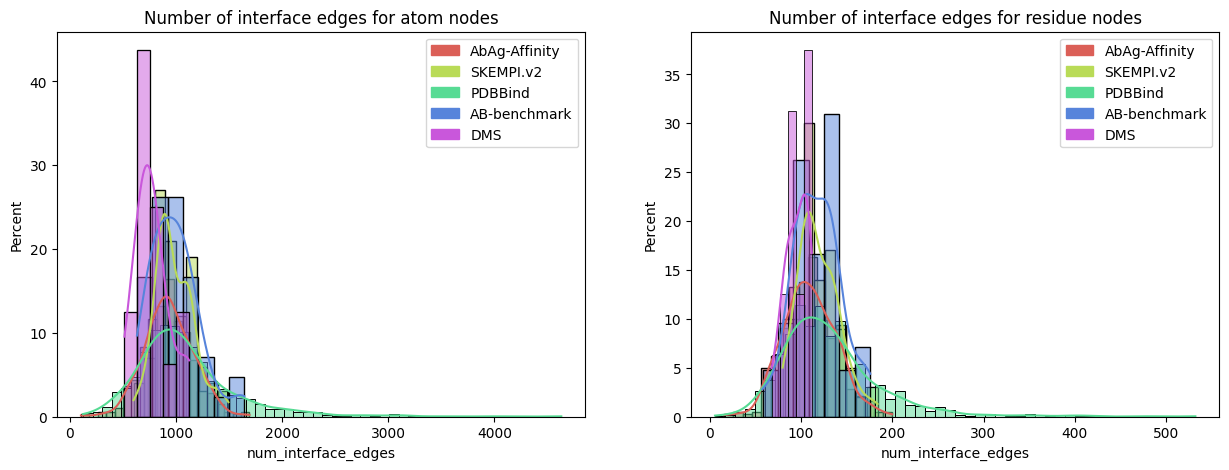

In [17]:
plot_histograms("num_interface_edges", "Number of interface edges for {} nodes")
plt.savefig(f"./plots/dataset_comparison_num_interface_edge_distribution.png")


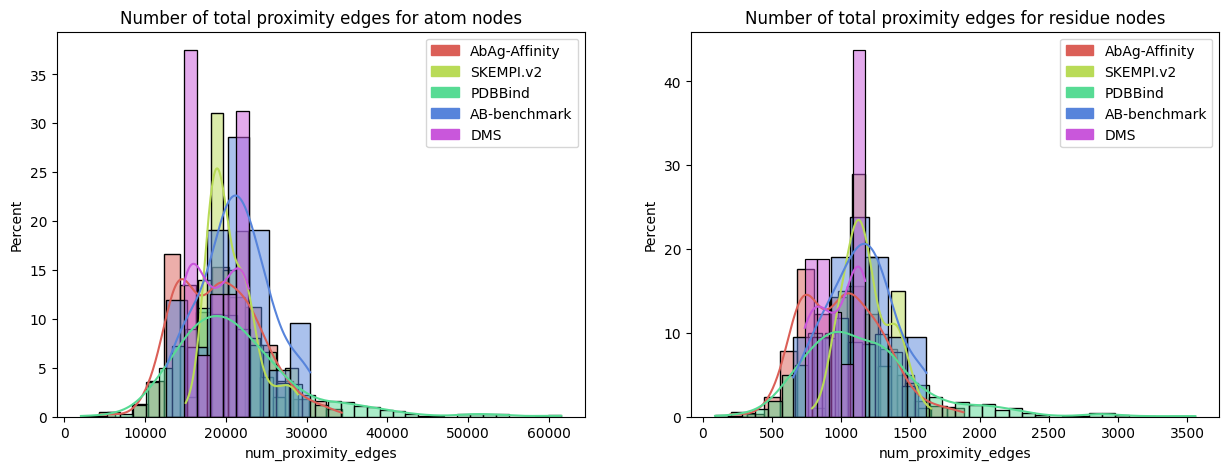

In [18]:
plot_histograms("num_proximity_edges", "Number of total proximity edges for {} nodes")
plt.savefig(f"./plots/dataset_comparison_num_proximity_edge_distribution.png")


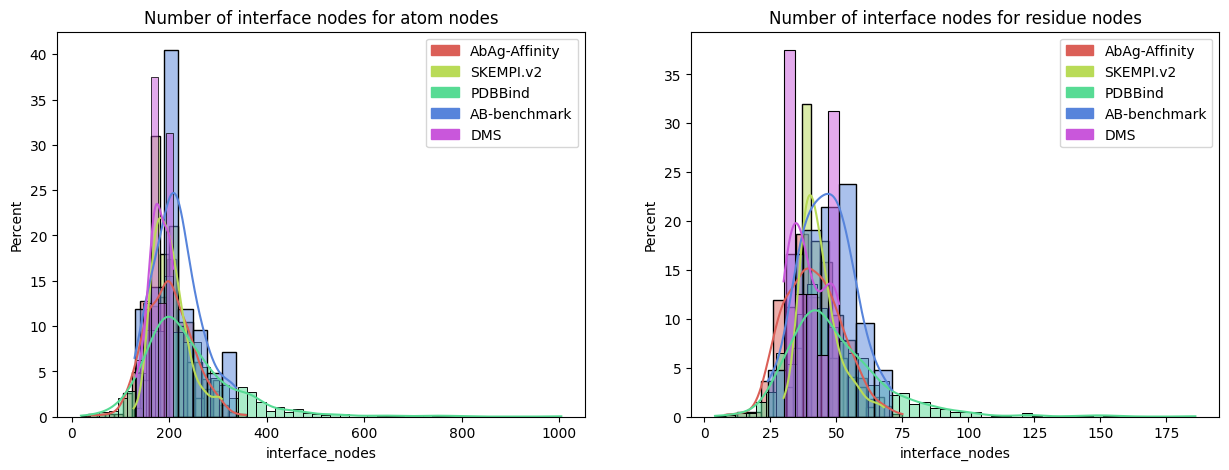

In [19]:
plot_histograms("interface_nodes", "Number of interface nodes for {} nodes")
plt.savefig(f"./plots/dataset_comparison_interface_nodes_distribution.png")


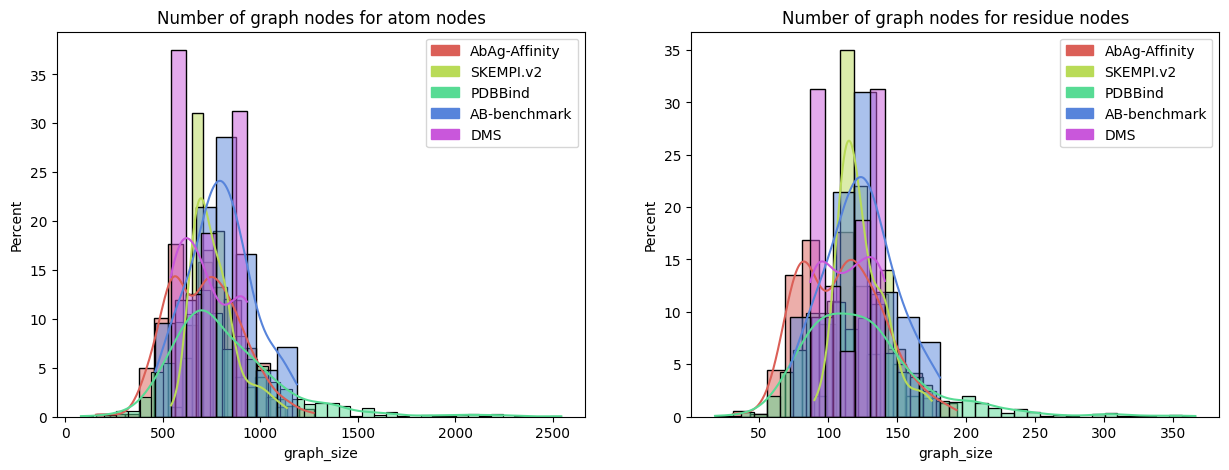

In [20]:
plot_histograms("graph_size", "Number of graph nodes for {} nodes")
plt.savefig(f"./plots/dataset_comparison_graph_size_distribution.png")

### Node type distribution

In [21]:
def plot_binding_residues(node_counts, node_type: str, ax=None, plot_x_frequent=20):
    plot_x_frequent = 10
    width = 0.15
    if ax is None:
        fix, ax = plt.subplots(1,1, figsize=(15,8))
    
    
    sorted_dict = {k: v for k, v in sorted(node_counts[name_mapping["abag_affinity"]].items(), key=lambda item: item[1], reverse=True)}
    most_frequent_nodes = list(sorted_dict.keys())[:plot_x_frequent]
    indices = np.arange(min(plot_x_frequent, len(most_frequent_nodes)))

    subplots = []
    for i, dataset_name in enumerate(node_counts.keys()):
        subplots.append(ax.bar(indices + width * i, [node_counts[dataset_name][node] for node in most_frequent_nodes], width=width, align='center'))
    ax.set_xticks(indices + 1.5*width, [ key.capitalize() for key in sorted_dict.keys()][:plot_x_frequent])
    ax.set_title(f"{plot_x_frequent} most frequent {node_type}")

    ax.set_ylabel("Relative Frequency (%)")
    ax.legend( subplots, node_counts.keys() )


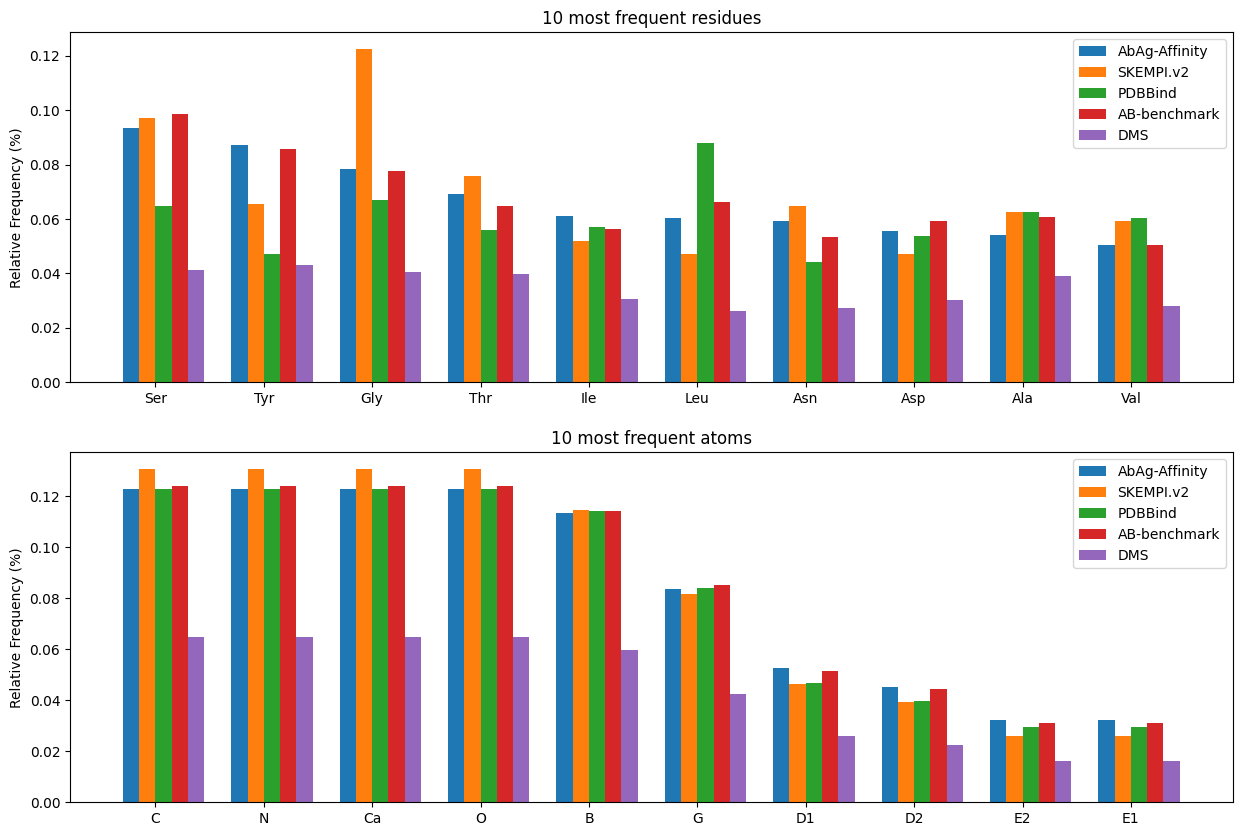

In [22]:
node_types = ["residue", "atom"]
fix, axs = plt.subplots(2,1, figsize=(15,10))

for i, node_type in enumerate(node_types):
    node_counts = {}
    for dataset_name in dataset_stats.keys():
        node_counts[name_mapping[dataset_name]] = dataset_stats[dataset_name][node_type]["node_count"]
    
    plot_binding_residues(node_counts, f"{node_type}s", ax=axs[i])
plt.savefig(f"./plots/dataset_comparison_full_protein_type_distribution.png")
plt.show()


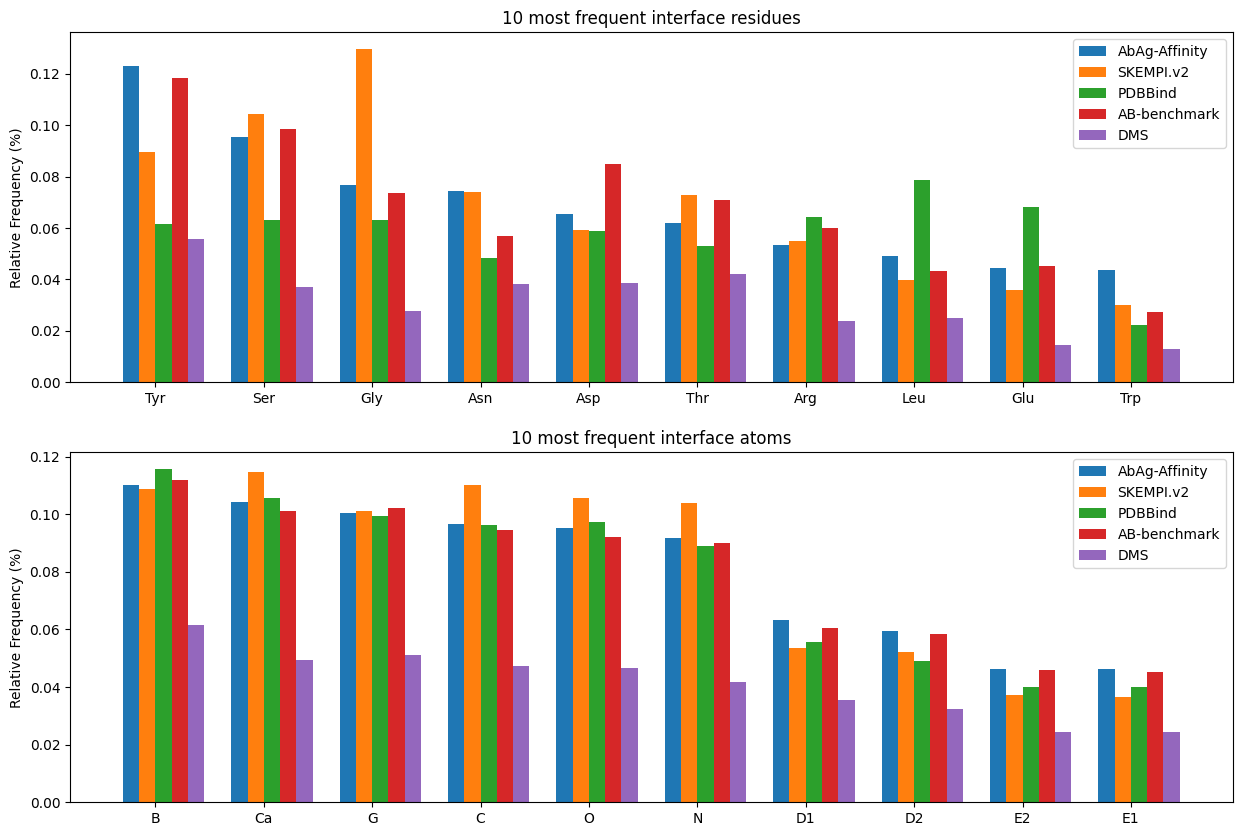

In [23]:
fix, axs = plt.subplots(2,1, figsize=(15,10))

for i, node_type in enumerate(node_types):
    node_counts = {}
    for dataset_name in dataset_stats.keys():
        node_counts[name_mapping[dataset_name]] = dataset_stats[dataset_name][node_type]["interface_node_count"]
    
    plot_binding_residues(node_counts, f"interface {node_type}s", ax=axs[i])
    
plt.savefig(f"./plots/dataset_comparison_interface_type_distribution.png")
plt.show()

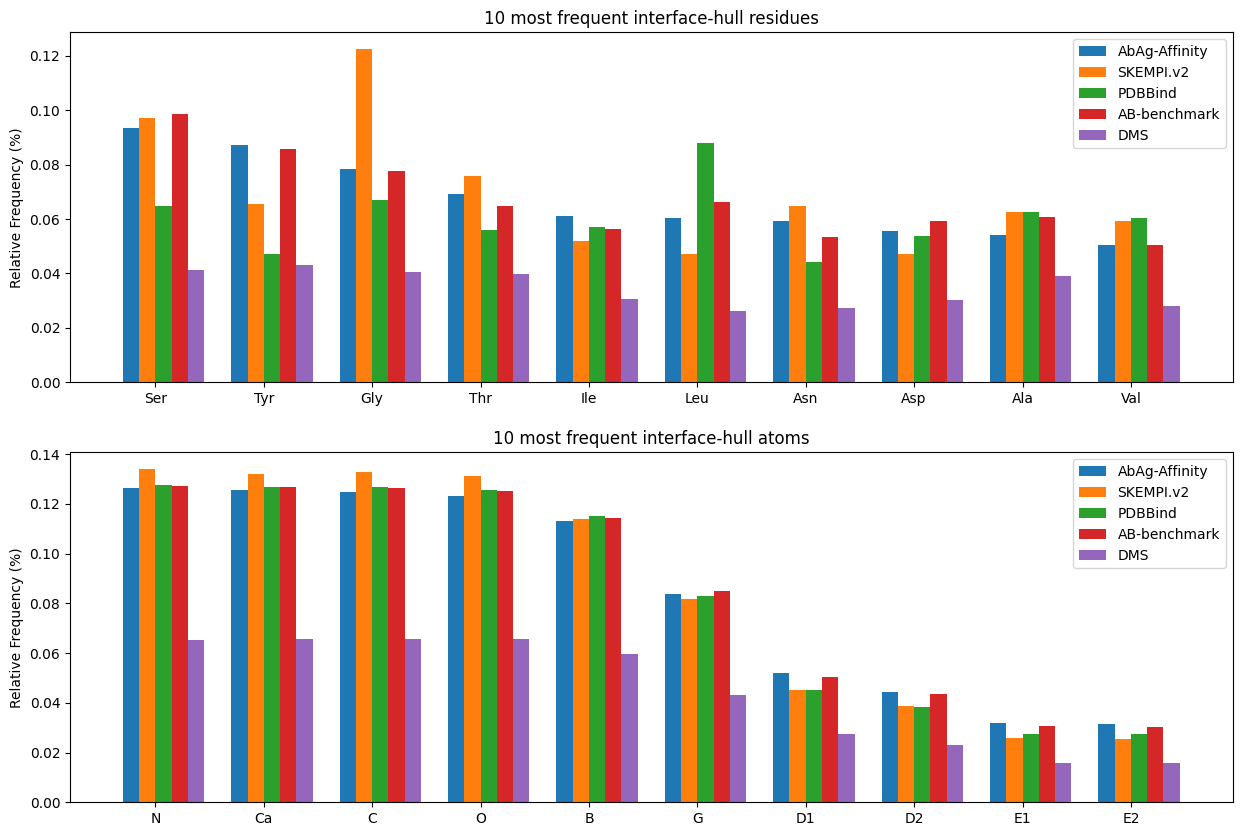

In [24]:
fix, axs = plt.subplots(2,1, figsize=(15,10))

for i, node_type in enumerate(node_types):
    node_counts = {}
    for dataset_name in dataset_stats.keys():
        node_counts[name_mapping[dataset_name]] = dataset_stats[dataset_name][node_type]["interface_hull_node_count"]
    
    plot_binding_residues(node_counts, f"interface-hull {node_type}s", ax=axs[i])

plt.savefig(f"./plots/dataset_comparison_interface_hull_type_distribution.png")
plt.show()

## Affinity comparison

In [25]:

all_data_points = []

for dataset_name in datasets:           
    if dataset_name == "DMS": # DMS data
        all_initial_dms_complexes = []
        for publication in config["DATASETS"]["DMS"]["affinity_types"].keys():
            summary_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"]["DMS"]["folder_path"], publication + ".csv")
            pdb_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"]["DMS"]["folder_path"], config["DATASETS"]["DMS"]["mutated_pdb_path"], publication)

            dataset = pd.read_csv(summary_path, index_col=0)    
            dataset_name = "DMS"
            all_initial_dms_complexes.append(dataset.drop_duplicates(subset='pdb', keep='first'))
        dataset = pd.concat(all_initial_dms_complexes)
    else:
        summary_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"][dataset_name]["folder_path"], config["DATASETS"][dataset_name]["summary"])
        pdb_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"][dataset_name]["folder_path"], config["DATASETS"][dataset_name]["pdb_path"])

        dataset = pd.read_csv(summary_path, index_col=0)
    
        dataset = dataset.drop_duplicates(subset='pdb', keep='first')
        
    dataset = dataset[["pdb", "-log(Kd)"]]
    dataset["dataset"] = dataset_name
    all_data_points.append(dataset)
    
all_data_df = pd.concat(all_data_points)
len(all_data_points)

5

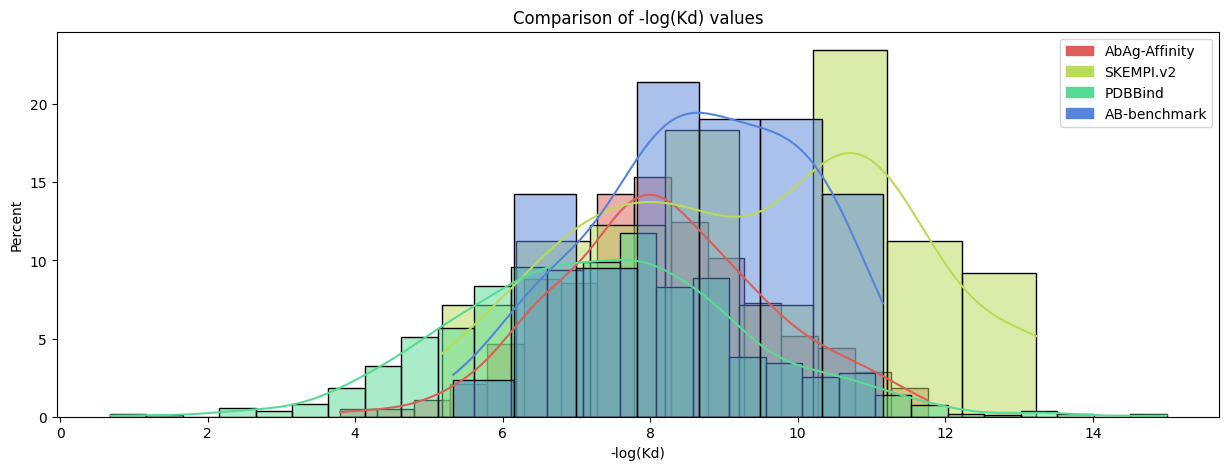

In [26]:
colors = sns.color_palette("hls", 5)

datasets_in_focus = datasets[:-1]

fig, axs = plt.subplots(1, 1, figsize=(15,5))
i = 0
    
color_bar = {}
min_val = np.inf
max_val = -np.inf

for ii, dataset_name in enumerate(datasets_in_focus):
    if dataset_name == "DMS": # DMS data
        all_initial_dms_complexes = []
        for publication in config["DATASETS"]["DMS"]["affinity_types"].keys():
            summary_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"]["DMS"]["folder_path"], publication + ".csv")
            pdb_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"]["DMS"]["folder_path"], config["DATASETS"]["DMS"]["mutated_pdb_path"], publication)

            dataset = pd.read_csv(summary_path, index_col=0)    
            dataset_name = "DMS"
            all_initial_dms_complexes.append(dataset.drop_duplicates(subset='pdb', keep='first'))
        dataset = pd.concat(all_initial_dms_complexes)
    else:
        summary_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"][dataset_name]["folder_path"], config["DATASETS"][dataset_name]["summary"])
        pdb_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"][dataset_name]["folder_path"], config["DATASETS"][dataset_name]["pdb_path"])

        dataset = pd.read_csv(summary_path, index_col=0)
    
        dataset = dataset.drop_duplicates(subset='pdb', keep='first')
        
        min_val = min(min_val, min(dataset["-log(Kd)"]))
        max_val = max(max_val, max(dataset["-log(Kd)"]))
    
    ax = sns.histplot(dataset,  x="-log(Kd)", kde=True, ax=axs, stat="percent", color=colors[ii])
    color_bar[name_mapping[dataset_name]] = colors[ii]   

axs.set_title("Comparison of -log(Kd) values")
        
labels = list(color_bar.keys())
handles = [plt.Rectangle((0,0),1,1, color=color_bar[label]) for label in labels]
axs.legend(handles, labels)

plt.savefig(f"./plots/dataset_comparison_-log(Kd)_distribution.png")


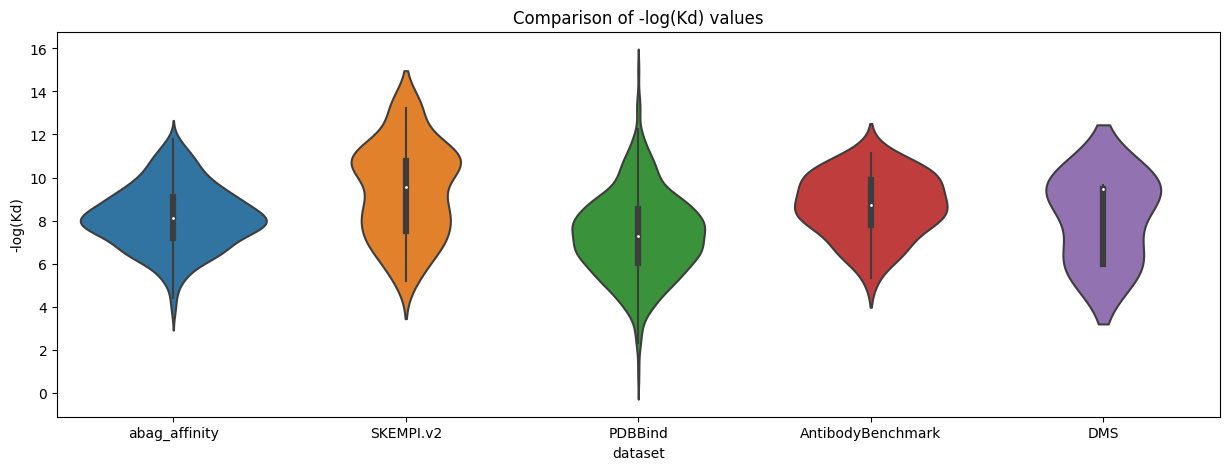

In [51]:
colors = sns.color_palette("hls", 5)

datasets_in_focus = datasets#[:-1]

fig, axs = plt.subplots(1, 1, figsize=(15,5))
i = 0
    
color_bar = {}
min_val = np.inf
max_val = -np.inf

all_datasets = []

for ii, dataset_name in enumerate(datasets_in_focus):
    if dataset_name == "DMS": # DMS data
        all_initial_dms_complexes = []
        for publication in config["DATASETS"]["DMS"]["affinity_types"].keys():
            summary_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"]["DMS"]["folder_path"], publication + ".csv")
            pdb_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"]["DMS"]["folder_path"], config["DATASETS"]["DMS"]["mutated_pdb_path"], publication)

            dataset = pd.read_csv(summary_path, index_col=0)    
            dataset_name = "DMS"
            all_initial_dms_complexes.append(dataset.drop_duplicates(subset='pdb', keep='first'))
        dataset = pd.concat(all_initial_dms_complexes)    
    else:
        summary_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"][dataset_name]["folder_path"], config["DATASETS"][dataset_name]["summary"])
        pdb_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"][dataset_name]["folder_path"], config["DATASETS"][dataset_name]["pdb_path"])

        dataset = pd.read_csv(summary_path, index_col=0)
    
        dataset = dataset.drop_duplicates(subset='pdb', keep='first')
    dataset["dataset"] = dataset_name
    all_datasets.append(dataset)
        
    min_val = min(min_val, min(dataset["-log(Kd)"]))
    max_val = max(max_val, max(dataset["-log(Kd)"]))
    
    #ax = sns.histplot(dataset,  x="-log(Kd)", kde=True, ax=axs, stat="percent", color=colors[ii])
    #color_bar[name_mapping[dataset_name]] = colors[ii]   
    
    
all_datasets_df = pd.concat(all_datasets)
axs.set_title("Comparison of -log(Kd) values")
        
sns.violinplot(data=all_datasets_df, y="-log(Kd)", x="dataset")
plt.savefig(f"./plots/dataset_comparison_-log(Kd)_violin.png")


In [52]:
print("The minimal -log(Kd) value is", min_val)
print("The maximal -log(Kd) value is", max_val)

The minimal -log(Kd) value is 0.6736641390712486
The maximal -log(Kd) value is 15.0
